### Download the data

In [9]:
!wget https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv

--2022-08-29 21:54:45--  https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5998096 (5.7M) [text/plain]
Saving to: ‘AE_Data.csv.4’

AE_Data.csv.4       100%[===================>]   5.72M  --.-KB/s    in 0.05s   

2022-08-29 21:54:46 (106 MB/s) - ‘AE_Data.csv.4’ saved [5998096/5998096]



### Setup

In [10]:
! pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import re
import os
import shutil

import tensorflow_hub as hub
import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [12]:
df = pd.read_csv('/content/AE_Data.csv')
df.head()

,title,abstract,label
0,antimicrobial impacts of essential oils on foo...,the antimicrobial activity of twelve essential...,0
1,purification and characterization of a cystein...,antimicrobial peptide (amp) crustin is a type ...,0
2,telavancin activity tested against gram-positi...,objectives: to reassess the activity of telava...,0
3,the in vitro antimicrobial activity of cymbopo...,background: it is well known that cymbopogon (...,0
4,screening currency notes for microbial pathoge...,fomites are a well-known source of microbial i...,0


In [13]:
df['label'].value_counts()

0    3851
1     294
Name: label, dtype: int64

In [14]:
df['text'] = df['title'] + ' ' + df['abstract']
df.head()

,title,abstract,label,text
0,antimicrobial impacts of essential oils on foo...,the antimicrobial activity of twelve essential...,0,antimicrobial impacts of essential oils on foo...
1,purification and characterization of a cystein...,antimicrobial peptide (amp) crustin is a type ...,0,purification and characterization of a cystein...
2,telavancin activity tested against gram-positi...,objectives: to reassess the activity of telava...,0,telavancin activity tested against gram-positi...
3,the in vitro antimicrobial activity of cymbopo...,background: it is well known that cymbopogon (...,0,the in vitro antimicrobial activity of cymbopo...
4,screening currency notes for microbial pathoge...,fomites are a well-known source of microbial i...,0,screening currency notes for microbial pathoge...


In [15]:
# List to hold experiment
EXPERIMENT_RESULTS = []

### Helper Functions

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def parse_confusion_matrix(x):
  '''
  Function parses confusion matrix and 
  returns TP, TN, FP and FN for a binary classification model
  '''
  tn, fp, fn, tp = x.ravel()

  return [tp, tn, fp, fn]

def parse_clf_report(x):
  '''
  Functinon parses classificatin report dictionary
  '''

  f1 = x['weighted avg']['f1-score']
  precision = x['weighted avg']['precision']
  recall = x['weighted avg']['recall']
  positive_f1 = x['1']['f1-score']
  positive_precision = x['1']['precision']
  positive_recall = x['1']['recall']

  return [f1, precision, recall, positive_f1, positive_precision, positive_recall]

def prepare_exp_report(master_list, exp_name, confsn_mat, clf_rpt):
  '''
  Function prepares experiment report, 
  in a nutshell it's just concataneting few lists
  '''
  return master_list.append([exp_name] + confsn_mat + clf_rpt)

# Plotter function
def plot_history():
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

def train_model(num_epochs, train_batch_size):
  def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)


  classifier_model = build_classifier_model()

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()


  classifier_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)


  history = classifier_model.fit(X_train, y_train,
                                epochs=num_epochs,
                                batch_size=train_batch_size,
                                validation_data=(X_val, y_val))
  return classifier_model, history

### Train Val Test Split

Due to imbalanced dataset, we need to follow an innovative approach to split the data. There are ways in [numpy](https://stackoverflow.com/a/38251213/11383333), which can help with train, val, test split (still not present in sklearn), but we need to do the stratified sampling. So use the sklearn's data split 2 times

In [17]:
from sklearn.model_selection import train_test_split

val_split = 0.2
test_split = 0.2

X = df['text'].values
y = df['label'].values

# First split, split original dataset in train-val combination and test
X_comb, X_test, y_comb, y_test = train_test_split(X, y, test_size=test_split, stratify=y)

# Second split, split train-val combination into train and val dataset
X_train, X_val, y_train, y_val = train_test_split(X_comb, y_comb, test_size=val_split, stratify=y_comb)

In [18]:
print('Label Distribution in the training data')
print(np.unique(y_train, return_counts=True))
print('*'*50)
print('Label Distribution in the validation data')
print(np.unique(y_val, return_counts=True))
print('*'*50)
print('Label Distribution in the testing data')
print(np.unique(y_test, return_counts=True))

Label Distribution in the training data
(array([0, 1]), array([2464,  188]))
**************************************************
Label Distribution in the validation data
(array([0, 1]), array([617,  47]))
**************************************************
Label Distribution in the testing data
(array([0, 1]), array([770,  59]))


In [19]:
tfhub_handle_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
# tfhub_handle_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',trainable=True)
tfhub_handle_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

### Experiment 1 : BERT Out of the Box

In [20]:
EPOCHS = 5
BATCH_SIZE = 32
THRESHOLD = -0.4

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Epoch 1/5
83/83 [==============================] - 50s 420ms/step - loss: 0.3213 - binary_accuracy: 0.9268 - val_loss: 0.2388 - val_binary_accuracy: 0.9292
Epoch 2/5
83/83 [==============================] - 34s 407ms/step - loss: 0.2446 - binary_accuracy: 0.9295 - val_loss: 0.2271 - val_binary_accuracy: 0.9292
Epoch 3/5
83/83 [==============================] - 35s 424ms/step - loss: 0.2404 - binary_accuracy: 0.9284 - val_loss: 0.2284 - val_binary_accuracy: 0.9292
Epoch 4/5
83/83 [==============================] - 35s 423ms/step - loss: 0.2470 - binary_accuracy: 0.9287 - val_loss: 0.2289 - val_binary_accuracy: 0.9292
Epoch 5/5
26/26 [==============================] - 9s 333ms/step
[[767   3]
 [ 58   1]]


                    0          1  accuracy   macro avg  weighted avg
precision    0.929697   0.250000  0.926417    0.589848      0.881323
recall       0.996104   0.016949  0.926417    0.506527      0.926417
f1-score     0.961755   0.031746  0.926417    0.496751      0.895567
support   

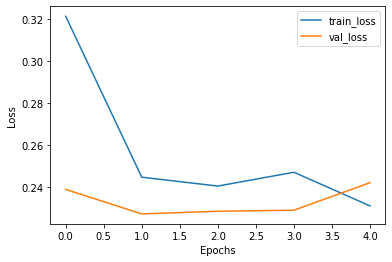

In [21]:
# Experiment name
exp_name1 = 'BERT - Out of the Box'

# Train the model
classifier_model, history = train_model(EPOCHS, BATCH_SIZE)

# Generate predictions
y_probs = classifier_model.predict(X_test)

# Convert probabilities to labels
y_pred = np.where(y_probs > THRESHOLD, 1, 0)

# Prepare Classification Report
exp_confusion_matrix = confusion_matrix(y_test,y_pred)
exp_clf_report = classification_report(y_test,y_pred, output_dict=True)
print('Confusion Matrix : ')
print(exp_confusion_matrix)
print('\n')
print('Classification Report : ')
print(pd.DataFrame(exp_clf_report))

# Prepare experiment results
prepare_exp_report(EXPERIMENT_RESULTS, 
                    exp_name1, 
                    parse_confusion_matrix(exp_confusion_matrix), 
                    parse_clf_report(exp_clf_report))

# Plot loss functions for training and validations
print('Model Training Results : ')
plot_history()

False Negatives are exactly what the model should not be catching. It's very important in business cases like this to focus on reducing the False Negatives. Overall, we can say that the **model performance is terrible in the context of the business case.**

In [22]:
SCHEMA = ['Experiment Name', 'True Positives', 'True Negatives', 'False Positives', 
          'False Negatives', 'Overall F1 Score','Overall Precision','Overall Recall',
          'F1 for Positives Records','Precision for Positive Records', 'Recall for Positive Records']

pd.DataFrame(EXPERIMENT_RESULTS, columns=SCHEMA)

,Experiment Name,True Positives,True Negatives,False Positives,False Negatives,Overall F1 Score,Overall Precision,Overall Recall,F1 for Positives Records,Precision for Positive Records,Recall for Positive Records
0,BERT,1,767,3,58,0.895567,0.881323,0.926417,0.031746,0.25,0.016949
